# พลอตภาพอินฟราเรด GOES-13

นิสิตจะได้เรียนรู้
* การอ่านข้อมูลอินฟราเรด 
* การแปลงค่า raw count เป็นค่า radiance และแปลงไปสู่ค่า อุณหภูมิส่องสว่าง (brightness temperature)
* การพลอตแผนที่ดาวเทียมจากค่าอุณหภูมิส่องสว่างที่คำนวณได้จากแบนด์อินฟราเรด


โค้ดได้มาจาก MetPy Monday ลิงก์ https://www.youtube.com/watch?v=mfBpAV2Zd6w&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=42


แหล่งเรียนรู้ดาวเทียมอุตุนิยมวิทยา
* Dr.Kevin Perry จากมหาวิทยาลัยยูท่าห์ สอนเรื่องดาวเทียมอุตุนิยมวิทยา ดีมาก https://www.youtube.com/watch?v=WK0NyUdnsqQ

## นำเข้าไลบราลี่

In [1]:
# นำเข้าไลบราลี่
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np

In [2]:
# ตัวแปรไฟล์ชาแนล 4 คือ อินฟราเรดของ GOES13
file_ir ='goes13.2011.117.200229.BAND_04.nc'

In [3]:
#อ่านข้อมูลอินฟราเรดมาเก็บในตัวแปร
ds_ir = Dataset(file_ir, 'r')

In [4]:
list(ds_ir.variables)

['version',
 'sensorID',
 'imageDate',
 'imageTime',
 'startLine',
 'startElem',
 'time',
 'dataWidth',
 'lineRes',
 'elemRes',
 'prefixSize',
 'crDate',
 'crTime',
 'bands',
 'auditTrail',
 'data',
 'lat',
 'lon']

In [5]:
#แปลงข้อมูลจาก 16 บิทไปเป็น 10 บิท
ir_10bit = ds_ir.variables['data'][0]/32 

In [6]:
#มีความแตกต่างของ resolution ระหว่าง visible กับ infrared 
# mask ค่าสูงของ infrared
lat_ir = np.ma.masked_values(ds_ir.variables['lat'][:], 2.14329e+09) # 2.14329e+09 เป็นค่าพิกัดสูงสุดที่เกินจริงที่ต้อง mask ไว้ว่าจะไม่เอาใช้ 
lon_ir = np.ma.masked_values(ds_ir.variables['lon'][:], 2.14329e+09)

In [7]:
# ทำการ mask
ir_masked = np.ma.masked_array(ir_10bit, mask=lat_ir.mask)

## แปลงค่า RAW count ไปเป็น Bightness temperature
* ต้องแปลงค่า Raw count ไปเป็นค่า brightness temperature สำหรับข้อมูลแบนด์อินฟราเรด
* เข้าไปที่ https://www.ospo.noaa.gov/Operations/GOES/calibration/index.html แล้วเลือกLearn how to convert GVAR counts to temperature in the infrared channels!  จะไปที่ลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html อธิกระบวนการสองขั้นด้วยกันคือ 
    * Conversion of Imager GVAR Count to Scene Radiance สมการ R=(X-b)/m ดูตาราง 1-2 ใน channel ที่ 4 เพื่อใช้ค่า m และ b ลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html#scene
    * Conversion of Imager GVAR Count to Temperature สมการ Teff ลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html#temp

In [8]:
# ค่า m และ b จากตาราง 1-2
m_ir = 5.2285
b_ir =15.6854

#คำนวนค่า R นั่นคือค่า Radiance
R_ir = (ir_masked - b_ir)/m_ir

In [9]:
# คำนวนค่า Teff 

#กำหนดค่า inverse pluck function constants
c1 = 1.191066e-5
c2 = 1.438833


In [10]:
# ใช้ค่าจากตาราง 2-6 GOES-13 สำหรับแบนด์ 4 เพื่อใช้ค่า v กับ alfa และ beta
v_ir = 937.23

u_ir = -0.386043 #alfa

bt_ir = 1.001298 #beta

In [11]:
# คำนวนค่า Teff 
T_eff_ir = (c2*v_ir)/(np.log(1+(c1*v_ir**3)/R_ir)) # invalid value encountered in log เกิดจาก missing value ไม่มีปัญหา

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [12]:
# คำนวณหาค่าอุณหภูมิส่องสว่างจากแบนด์อินฟราเรด Brightness Temperature
BT_ir = u_ir + bt_ir * T_eff_ir
BT_ir.max() #ตรวจสอบ Brightness Temperature ของพื้นผิว

331.24628

### พลอตแผนที่ค่า Brightness Temperature


C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\cr

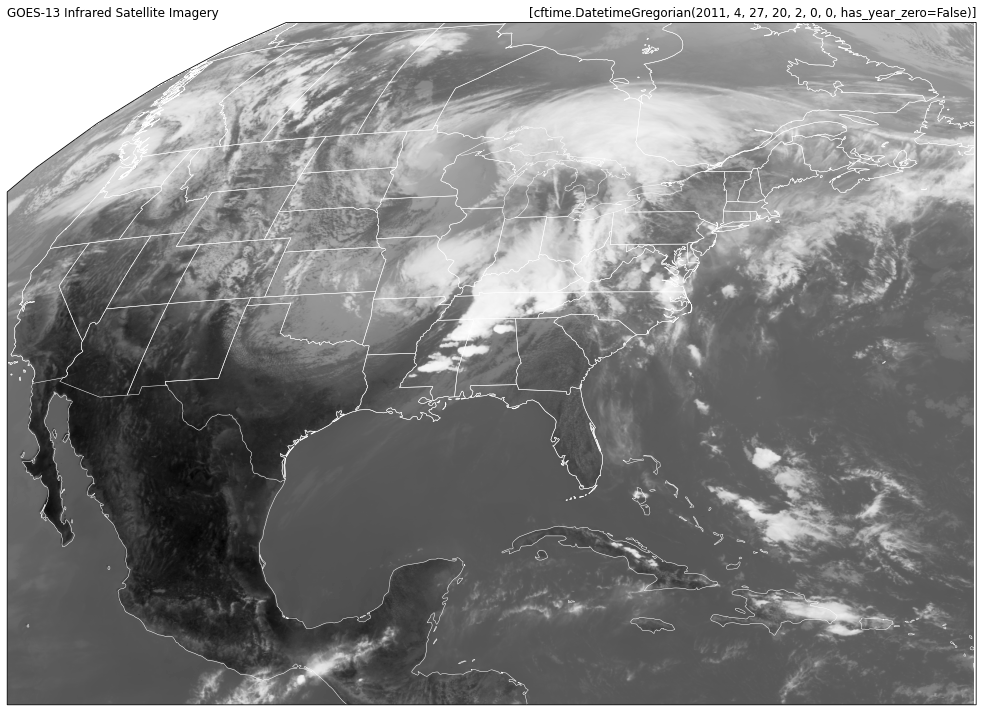

In [13]:
import numpy as np
# พลอตแผนที่ค่า Brightness Temperature
vtime = num2date(ds_ir.variables['time'][:], units=ds_ir.variables['time'].units) #เซตค่าตัวแปรเวลา

mapcrs = ccrs.Geostationary(central_longitude=-75)

# หาค่า max min index ที่อยู่ในรูปของพิกัดภูมิศาสตร์ แล้วจะทำการแปลงไปเป็นระบบพิกัด Geostationary
ilon_min = np.unravel_index(np.argmin(lon_ir), lon_ir.shape) #หาอินเด็กซ์ของลองจิจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D
ilon_max = np.unravel_index(np.argmax(lon_ir), lon_ir.shape) #หาอินเด็กซ์ของลองจิจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D

ilat_min = np.unravel_index(np.argmin(lat_ir), lat_ir.shape) #หาอินเด็กซ์ของละติจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D
ilat_max = np.unravel_index(np.argmax(lat_ir), lat_ir.shape) #หาอินเด็กซ์ของละติจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D

#แปลงไปเป็นระบบพิกัด Geostationary
LONpt0 = mapcrs.transform_point(lon_ir[ilon_min],lat_ir[ilon_min], ccrs.Geodetic() )[0]
LONpt1 = mapcrs.transform_point(lon_ir[ilon_max],lat_ir[ilon_max], ccrs.Geodetic() )[0]

LATpt0 = mapcrs.transform_point(lon_ir[ilat_min],lat_ir[ilat_min], ccrs.Geodetic() )[1]
LATpt1 = mapcrs.transform_point(lon_ir[ilat_max],lat_ir[ilat_max], ccrs.Geodetic() )[1]

fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

img = ax.imshow(BT_ir, cmap='Greys', origin='upper',   #BT_r และเปลี่ยนเป็น Greys
                extent=(LONpt0, LONpt1, LATpt0, LATpt1)) 

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth = 0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white', linewidth = 0.5)

plt.title(vtime, loc='right')
plt.title('GOES-13 Infrared Satellite Imagery', loc='left')

plt.tight_layout()
plt.show()

* สีขาวสว่าง คือ อุณหภูมิที่ต่ำมากๆ นั่นคือเมฆที่สูงมากๆ ในขณะที่เมฆต่ำจะสีเทาๆ ส่วนพื้นดินสีดำจะเป็นบริเวณที่ปลอดเมฆ หรืออุณหภูมิสูงนั่นเอง
* ท้องทะเลจะมีสีเทา เมื่อเทียบกับแผ่นดินที่มีสีดำ เนื่องจากน้ำทะเลมีอุณหภูมิที่ต่ำกว่าพื้นดิน
* ต่อไปเราจะทำการพลอตข้อมูลไอน้ำในอากาศ water vapor ของ GOES 13

### งานมอบหมายนิสิต
* ให้นิสิตดาวน์โหลดข้อมูลวันที่ 26 และ 28 สิงหาคม 2011 ของข้อมูล GOES13 ซึ่งเป็นช่วงที่พายุเฮอริเคน Irene พัดเข้ามาในพื้นที่ทางตะวันออกของประเทศสหรัฐอเมริกา อ่านจากลิงก์นี้ https://en.wikipedia.org/wiki/Hurricane_Irene
* ให้นิสิตทำการพลอตข้อมูลอุณหภูมิส่องสว่าง โดยใช้โค้ดด้านบน
* ให้นิสิตบรรยายผลที่ได้จากภาพดาวเที่ยม โดยเปรียบเทียบระหว่างข้อมูลสองวันดังกล่าว 